# Exploration of power metrics and baseline
### Maria Silva, May 2022


***

**TLDR**

In this notebook, we analyze how raw-byte power, quality-adjusted power, and baseline power evolved historically.  In particular, we investigate all the available historical data, until the end of May 2022.  We make the following observations from the data:

1. After the network launch in 2020,  network power experienced very high growth. Growth rates were significantly above the 6% baseline growth and, as a consequence, Filecoin crossed the Baseline power in April 2021.

2. Since the launch, monthly growth rates experienced a general downward trend. This is not unexpected, since there was an explosion of adoption in the beginning and, as the network expands, maintaining the same level of growth becomes harder. However, after the summer of 2021, growth rates decreased significantly and, in December 2021, power growth became lower than the baseline growth. We suspect that this is a consequence of China's crackdown on crypto since a big part of SPs were in that region.

3. In 2022, this trend was further worsened. We see another large drop in monthly growth during February, which led to the lowest growth observed (less than 0.5%). 

4. After February 2022, growth rates have seen increasing slightly, going up to a rate between 2% and 3%. We also see a take-off of Filecoin Plus, with the quality-adjusted power growing at a 1% higher rate than raw-byte power. Still, the network continues to grow slower than the 6% baseline.


In conclusion, network power has experienced a shift since China's crackdown in the summer of 2021. Monthly growth rates are still well below the baseline and, if they keep belew 6%, the network power will inevitably go below the baseline power in the future.

On a more positive note, we do see an upward trend in the monthly growth rates since February 2022. Another interesting trend is the increase in Filcoin Plus. This means that even though the network is not growing at the baseline rate, it is adding more useful data, which is the end goal of Filecoin. 

***

## 1. Imports and data processing

In [1]:
import os
import numpy as np
import pandas as pd
import altair as alt
import warnings
import datetime

warnings.filterwarnings('ignore')
alt.renderers.enable('mimetype')

data_folder = os.path.abspath(os.path.join(os.getcwd(), "../../../..", "Sentinel"))

#### Power stats

In [2]:
power_file = os.path.join(data_folder, "chain_powers.csv")
power_df = pd.read_csv(power_file)

# Compute timestamps from height
c = 1598306430
power_df["timestamp"] = c + (power_df["height"]-1)*30

# Get dates from timestamps
power_df["date"] = pd.to_datetime(power_df["timestamp"], unit="s")

# Get daily records
power_df = power_df[power_df["date"].dt.time == datetime.time(23, 59, 30)]

# Convert bytes to exbibytes
eib_convertion = 2**60
power_df[["total_raw_power", "total_qa_power"]] = power_df[['total_raw_bytes_power', "total_qa_bytes_power"]].astype(float)/eib_convertion

# Select columns
power_df = power_df[["height", "date", "miner_count", "participating_miner_count", "total_raw_power", "total_qa_power"]]

# Compute monthly percentage changes
power_df['month_raw_power_growth'] = power_df['total_raw_power'].pct_change(periods=30)
power_df['month_qa_power_growth'] = power_df['total_qa_power'].pct_change(periods=30)

# Drop Nulls
print(len(power_df))
power_df = power_df.dropna()
print(len(power_df))

# check clean data
power_df.head()

637
607


,height,date,miner_count,participating_miner_count,total_raw_power,total_qa_power,month_raw_power_growth,month_qa_power_growth
84715,86639,2020-09-23 23:59:30,14237,227,0.295990,0.295990,6465.009766,645.600977
87557,89519,2020-09-24 23:59:30,14310,237,0.306876,0.306876,38.316289,36.345106
90398,92399,2020-09-25 23:59:30,14367,231,0.309335,0.309335,17.354862,16.705617
93238,95279,2020-09-26 23:59:30,14384,224,0.316792,0.316792,10.947169,10.764383
96093,98159,2020-09-27 23:59:30,14416,222,0.327055,0.327261,7.864062,7.771700


#### Baseline stats

In [3]:
baseline_file = os.path.join(data_folder, "chain_rewards.csv")
baseline_df = pd.read_csv(baseline_file)

# Compute timestamps from height
c = 1598306430
baseline_df["timestamp"] = c + (baseline_df["height"]-1)*30

# Get dates from timestamps
baseline_df["date"] = pd.to_datetime(baseline_df["timestamp"], unit="s")

# Get daily records
baseline_df = baseline_df[baseline_df["date"].dt.time == datetime.time(23, 59, 30)]

# Convert bytes to exbibytes
eib_convertion = 2**60
baseline_df["baseline_power"] = baseline_df["new_baseline_power"].astype(float)/eib_convertion

# Compute monthly percentage changes
baseline_df['month_baseline_power_growth'] = baseline_df['baseline_power'].pct_change(periods=30)

# Select columns
baseline_df = baseline_df[["height", "date", "baseline_power", "month_baseline_power_growth"]]

# Drop Nulls
print(len(baseline_df))
baseline_df = baseline_df.dropna()
print(len(baseline_df))

# Check clean data
baseline_df.head()

637
607


,height,date,baseline_power,month_baseline_power_growth
84722,86639,2020-09-23 23:59:30,1.094773,0.094499
87564,89519,2020-09-24 23:59:30,1.098073,0.094499
90405,92399,2020-09-25 23:59:30,1.101383,0.094499
93245,95279,2020-09-26 23:59:30,2.507824,1.484660
96100,98159,2020-09-27 23:59:30,2.512591,1.481902


#### Join datasets

In [4]:
df = power_df.merge(baseline_df.drop(columns=["date"]), on="height", how="inner")
print(len(df))
df.head()

607


,height,date,miner_count,participating_miner_count,total_raw_power,total_qa_power,month_raw_power_growth,month_qa_power_growth,baseline_power,month_baseline_power_growth
0,86639,2020-09-23 23:59:30,14237,227,0.295990,0.295990,6465.009766,645.600977,1.094773,0.094499
1,89519,2020-09-24 23:59:30,14310,237,0.306876,0.306876,38.316289,36.345106,1.098073,0.094499
2,92399,2020-09-25 23:59:30,14367,231,0.309335,0.309335,17.354862,16.705617,1.101383,0.094499
3,95279,2020-09-26 23:59:30,14384,224,0.316792,0.316792,10.947169,10.764383,2.507824,1.484660
4,98159,2020-09-27 23:59:30,14416,222,0.327055,0.327261,7.864062,7.771700,2.512591,1.481902


## 2. Total power evolution

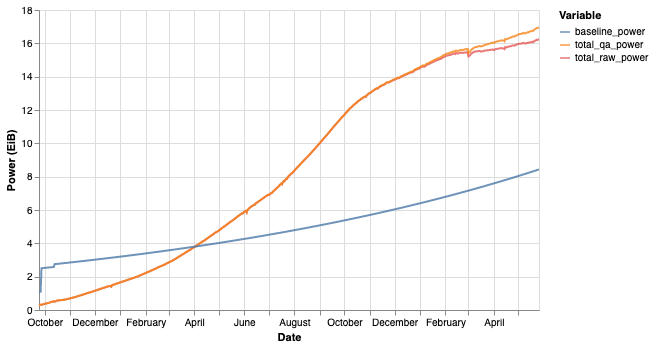

In [5]:
plot_vars = ["total_raw_power", "total_qa_power", "baseline_power"]
source = df.melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('value:Q', title="Power (EiB)"),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

## 3. Monthly power growth

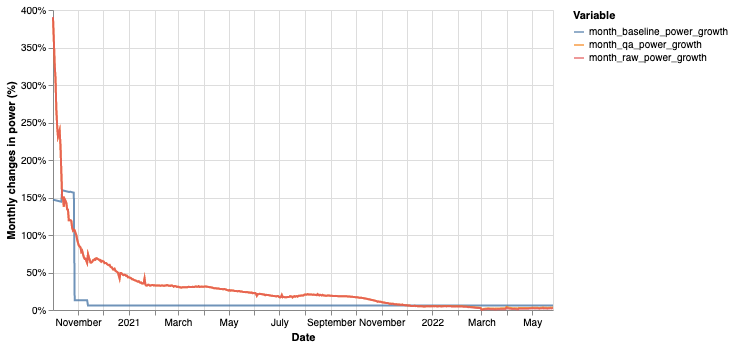

In [6]:
plot_vars = ["month_baseline_power_growth", "month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2020, 10, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('value:Q', title="Monthly changes in power (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

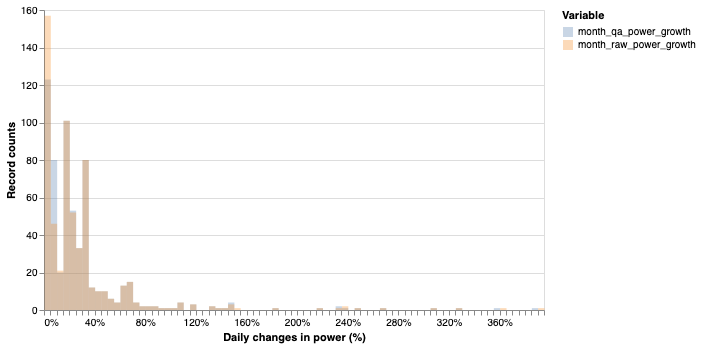

In [7]:
plot_vars = ["month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2020, 10, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_bar(
    opacity=0.3,
    binSpacing=0
).encode(
    alt.X('value:Q', bin=alt.Bin(maxbins=100), title="Daily changes in power (%)", axis=alt.Axis(format='%')),
    alt.Y('count()', stack=None, title="Record counts"),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

In [8]:
df_filter = df[df["date"]> datetime.datetime(2020, 10, 1)]
df_filter[["month_qa_power_growth", "month_raw_power_growth"]].agg(["mean", "std", "median"]).multiply(100).round(3).astype(str) + "%"

,month_qa_power_growth,month_raw_power_growth
mean,28.833%,28.651%
std,42.58%,42.789%
median,19.002%,18.995%


## 4. Montly power growth - China crackdown (July 2021)

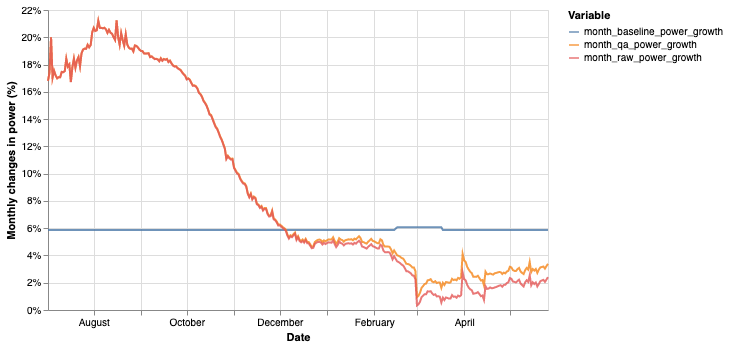

In [9]:
plot_vars = ["month_baseline_power_growth", "month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2021, 7, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('value:Q', title="Monthly changes in power (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

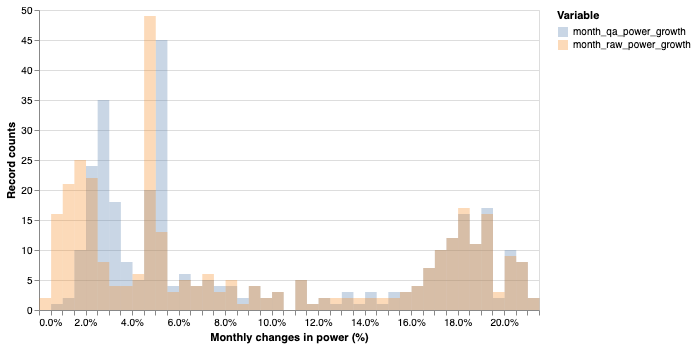

In [10]:
plot_vars = ["month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2021, 7, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_bar(
    opacity=0.3,
    binSpacing=0
).encode(
    alt.X('value:Q', bin=alt.Bin(maxbins=100), title="Monthly changes in power (%)", axis=alt.Axis(format='%')),
    alt.Y('count()', stack=None, title="Record counts"),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

In [11]:
df_filter = df[df["date"]> datetime.datetime(2021, 7, 1)]
df_filter[["month_qa_power_growth", "month_raw_power_growth"]].agg(["mean", "std", "median"]).multiply(100).round(3).astype(str) + "%"

,month_qa_power_growth,month_raw_power_growth
mean,9.321%,8.962%
std,6.796%,7.118%
median,5.371%,5.188%


## 5. Monthly power growth - Recent trend (2022)

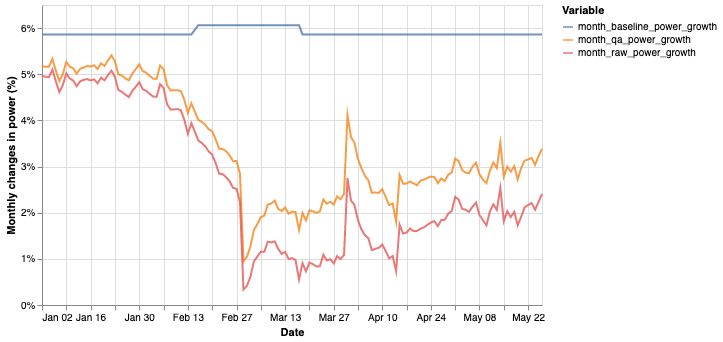

In [12]:
plot_vars = ["month_baseline_power_growth", "month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2022, 1, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_line(opacity=0.8).encode(
    x=alt.X('date:T', title="Date"),
    y=alt.Y('value:Q', title="Monthly changes in power (%)", axis=alt.Axis(format='%')),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

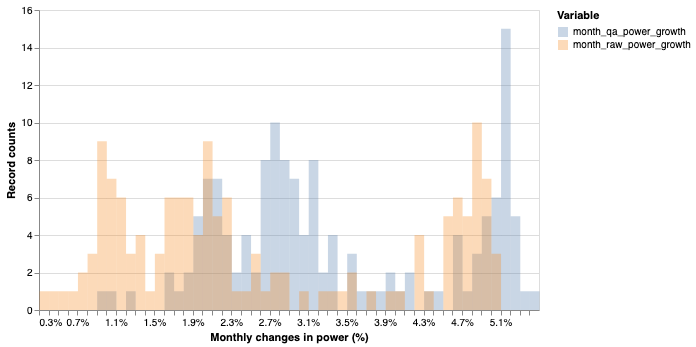

In [13]:
plot_vars = ["month_qa_power_growth", "month_raw_power_growth"]
source = df[df["date"]> datetime.datetime(2022, 1, 1)].melt(id_vars=["date"], value_vars=plot_vars)

alt.Chart(source).mark_bar(
    opacity=0.3,
    binSpacing=0
).encode(
    alt.X('value:Q', bin=alt.Bin(maxbins=100), title="Monthly changes in power (%)", axis=alt.Axis(format='%')),
    alt.Y('count()', stack=None, title="Record counts"),
    color=alt.Color('variable:N', legend=alt.Legend(title="Variable"))
).properties(
    width=500, height=300
)

In [14]:
df_filter = df[df["date"]> datetime.datetime(2022, 1, 1)]
df_filter[["month_qa_power_growth", "month_raw_power_growth"]].agg(["mean", "std", "median"]).multiply(100).round(3).astype(str) + "%"

,month_qa_power_growth,month_raw_power_growth
mean,3.385%,2.622%
std,1.207%,1.499%
median,3.003%,2.075%
